In [1]:
%cd /content/drive/MyDrive/Colab Notebooks/StockGuide

/content/drive/MyDrive/Colab Notebooks/StockGuide


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Bidirectional, Attention, Concatenate
from tensorflow.keras.callbacks import EarlyStopping

In [59]:
data = pd.read_csv('./data/삼성전자.csv', parse_dates=['날짜'], index_col='날짜')
data.sort_index(inplace=True)
data.head()

,종가
날짜,
2011-01-03,19160
2011-01-04,19160
2011-01-05,18840
2011-01-06,18600
2011-01-07,18420


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45216 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51676 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 45216 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51676 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51333 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44032 missing from current font.
  font.set_text

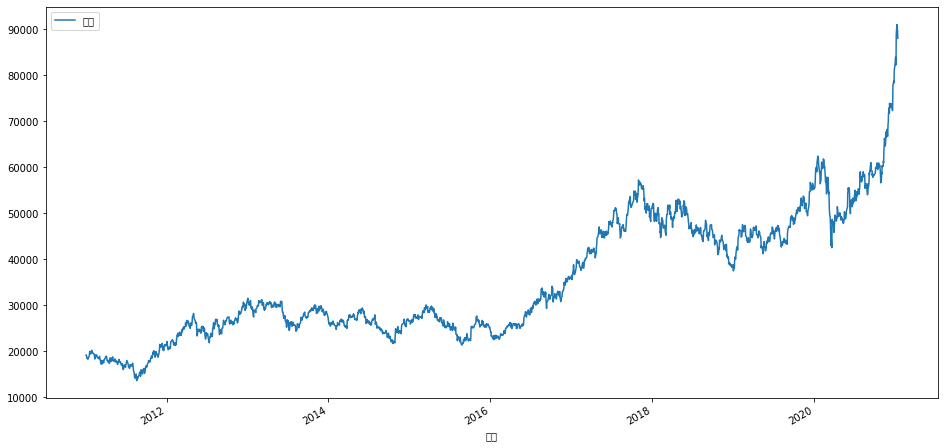

In [4]:
data.plot(figsize=(16,8))

In [60]:
time_step = 26
feature = 1

scaler = MinMaxScaler()
data['종가'] = scaler.fit_transform(data)

data['y_t+1'] = data['종가'].shift(-1)
for t in range(time_step-1, -1, -1):
    data['x_t-'+str(t)] = data['종가'].shift(t)
data.dropna(how='any', inplace=True)
data.head()

,종가,y_t+1,x_t-25,x_t-24,x_t-23,x_t-22,x_t-21,x_t-20,x_t-19,x_t-18,x_t-17,x_t-16,x_t-15,x_t-14,x_t-13,x_t-12,x_t-11,x_t-10,x_t-9,x_t-8,x_t-7,x_t-6,x_t-5,x_t-4,x_t-3,x_t-2,x_t-1,x_t-0
날짜,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-02-10,0.066150,0.060724,0.071835,0.071835,0.067700,0.064599,0.062274,0.061240,0.060207,0.064599,0.062532,0.065375,0.069509,0.074677,0.081912,0.078036,0.075194,0.075194,0.076227,0.082171,0.081137,0.085271,0.077778,0.078295,0.075452,0.072610,0.072351,0.066150
2011-02-11,0.060724,0.070543,0.071835,0.067700,0.064599,0.062274,0.061240,0.060207,0.064599,0.062532,0.065375,0.069509,0.074677,0.081912,0.078036,0.075194,0.075194,0.076227,0.082171,0.081137,0.085271,0.077778,0.078295,0.075452,0.072610,0.072351,0.066150,0.060724
2011-02-14,0.070543,0.071835,0.067700,0.064599,0.062274,0.061240,0.060207,0.064599,0.062532,0.065375,0.069509,0.074677,0.081912,0.078036,0.075194,0.075194,0.076227,0.082171,0.081137,0.085271,0.077778,0.078295,0.075452,0.072610,0.072351,0.066150,0.060724,0.070543
2011-02-15,0.071835,0.068475,0.064599,0.062274,0.061240,0.060207,0.064599,0.062532,0.065375,0.069509,0.074677,0.081912,0.078036,0.075194,0.075194,0.076227,0.082171,0.081137,0.085271,0.077778,0.078295,0.075452,0.072610,0.072351,0.066150,0.060724,0.070543,0.071835
2011-02-16,0.068475,0.070801,0.062274,0.061240,0.060207,0.064599,0.062532,0.065375,0.069509,0.074677,0.081912,0.078036,0.075194,0.075194,0.076227,0.082171,0.081137,0.085271,0.077778,0.078295,0.075452,0.072610,0.072351,0.066150,0.060724,0.070543,0.071835,0.068475


In [61]:
val_start = '2020-10-01'
test_start = '2020-12-01'

train = data[data.index <= val_start]
val = data[(data.index > val_start) & (data.index <= test_start)]
test = data[data.index > test_start]

X_train = train.iloc[:,2:].values
y_train = train.iloc[:,1].values
X_val = val.iloc[:,2:].values
y_val = val.iloc[:,1].values
X_test = test.iloc[:,2:].values
y_test = test.iloc[:,1].values

X_train = X_train.reshape(X_train.shape[0], time_step, feature)
X_val = X_val.reshape(X_val.shape[0], time_step, feature)
X_test = X_test.reshape(X_test.shape[0], time_step, feature)

X_train.shape, X_val.shape, X_test.shape

((2377, 26, 1), (41, 26, 1), (29, 26, 1))

# 1. RNN

In [62]:
model1 = Sequential()
model1.add(SimpleRNN(32, input_shape=(time_step, feature)))
model1.add(Dense(1, activation='linear'))

model1.compile(loss='mse', optimizer='adam')
model1.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 32)                1088      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 33        
Total params: 1,121
Trainable params: 1,121
Non-trainable params: 0
_________________________________________________________________


In [63]:
model1.fit(X_train, y_train,
           epochs=100,
           validation_data=(X_val, y_val))

Epoch 1/100
75/75 [==============================] - 2s 22ms/step - loss: 0.0023 - val_loss: 0.0015
Epoch 2/100
75/75 [==============================] - 1s 18ms/step - loss: 1.7146e-04 - val_loss: 9.3714e-04
Epoch 3/100
75/75 [==============================] - 1s 18ms/step - loss: 1.3779e-04 - val_loss: 0.0011
Epoch 4/100
75/75 [==============================] - 1s 19ms/step - loss: 1.4291e-04 - val_loss: 9.1776e-04
Epoch 5/100
75/75 [==============================] - 1s 17ms/step - loss: 1.2556e-04 - val_loss: 5.6176e-04
Epoch 6/100
75/75 [==============================] - 1s 18ms/step - loss: 1.3102e-04 - val_loss: 3.3677e-04
Epoch 7/100
75/75 [==============================] - 1s 19ms/step - loss: 1.5531e-04 - val_loss: 7.1159e-04
Epoch 8/100
75/75 [==============================] - 1s 18ms/step - loss: 1.0808e-04 - val_loss: 5.2458e-04
Epoch 9/100
75/75 [==============================] - 2s 21ms/step - loss: 1.0689e-04 - val_loss: 9.0053e-04
Epoch 10/100
75/75 [====================

In [64]:
model1.evaluate(X_test, y_test)

1/1 [==============================] - 0s 14ms/step - loss: 0.0016


0.0015709011349827051

In [65]:
result = pd.DataFrame(scaler.inverse_transform(test[['y_t+1']]), columns=['y_t+1'])
result['p_rnn'] = scaler.inverse_transform(model1.predict(X_test))
result.head()

,y_t+1,p_rnn
0,69700.0,68429.156250
1,71500.0,68405.929688
2,72900.0,70188.007812
3,71700.0,71625.429688
4,73900.0,70019.328125


# 2. LSTM

In [66]:
model2 = Sequential()
model2.add(LSTM(32, input_shape=(time_step, feature)))
model2.add(Dense(1, activation='linear'))

model2.compile(loss='mse', optimizer='adam')
model2.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 32)                4352      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 33        
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


In [67]:
model2.fit(X_train, y_train,
           epochs=100,
           validation_data=(X_val, y_val))

Epoch 1/100
75/75 [==============================] - 2s 8ms/step - loss: 0.0255 - val_loss: 7.5218e-04
Epoch 2/100
75/75 [==============================] - 0s 4ms/step - loss: 3.3355e-04 - val_loss: 7.9493e-04
Epoch 3/100
75/75 [==============================] - 0s 4ms/step - loss: 3.0954e-04 - val_loss: 8.6484e-04
Epoch 4/100
75/75 [==============================] - 0s 4ms/step - loss: 3.0313e-04 - val_loss: 8.7292e-04
Epoch 5/100
75/75 [==============================] - 0s 4ms/step - loss: 2.8456e-04 - val_loss: 0.0011
Epoch 6/100
75/75 [==============================] - 0s 4ms/step - loss: 2.6534e-04 - val_loss: 0.0012
Epoch 7/100
75/75 [==============================] - 0s 4ms/step - loss: 2.5495e-04 - val_loss: 0.0011
Epoch 8/100
75/75 [==============================] - 0s 3ms/step - loss: 2.3726e-04 - val_loss: 8.7038e-04
Epoch 9/100
75/75 [==============================] - 0s 4ms/step - loss: 2.4281e-04 - val_loss: 0.0011
Epoch 10/100
75/75 [==============================] - 1s 

In [68]:
model2.evaluate(X_test, y_test)

1/1 [==============================] - 0s 13ms/step - loss: 0.0011


0.001136834966018796

In [69]:
result['p_lstm'] = scaler.inverse_transform(model2.predict(X_test))
result.head()

,y_t+1,p_rnn,p_lstm
0,69700.0,68429.156250,68744.875000
1,71500.0,68405.929688,68874.125000
2,72900.0,70188.007812,70533.718750
3,71700.0,71625.429688,71988.460938
4,73900.0,70019.328125,70571.921875


# 3.Bi-LSTM

In [70]:
model3 = Sequential()
model3.add(Bidirectional(LSTM(32), input_shape=(time_step, feature)))
model3.add(Dense(1, activation='linear'))

model3.compile(loss='mse', optimizer='adam')
model3.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_4 (Bidirection (None, 64)                8704      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 65        
Total params: 8,769
Trainable params: 8,769
Non-trainable params: 0
_________________________________________________________________


In [71]:
model3.fit(X_train, y_train,
           epochs=100,
           validation_data=(X_val, y_val))

Epoch 1/100
75/75 [==============================] - 3s 17ms/step - loss: 0.0194 - val_loss: 0.0010
Epoch 2/100
75/75 [==============================] - 0s 6ms/step - loss: 4.5825e-04 - val_loss: 0.0013
Epoch 3/100
75/75 [==============================] - 0s 5ms/step - loss: 5.5250e-04 - val_loss: 8.5153e-04
Epoch 4/100
75/75 [==============================] - 0s 6ms/step - loss: 5.1755e-04 - val_loss: 0.0012
Epoch 5/100
75/75 [==============================] - 0s 6ms/step - loss: 4.5283e-04 - val_loss: 0.0011
Epoch 6/100
75/75 [==============================] - 0s 6ms/step - loss: 4.1497e-04 - val_loss: 0.0015
Epoch 7/100
75/75 [==============================] - 0s 6ms/step - loss: 3.6309e-04 - val_loss: 0.0013
Epoch 8/100
75/75 [==============================] - 0s 6ms/step - loss: 3.2091e-04 - val_loss: 0.0012
Epoch 9/100
75/75 [==============================] - 0s 6ms/step - loss: 2.6404e-04 - val_loss: 0.0013
Epoch 10/100
75/75 [==============================] - 0s 6ms/step - loss

In [72]:
model3.evaluate(X_test, y_test)

1/1 [==============================] - 0s 14ms/step - loss: 6.9564e-04


0.0006956445868127048

In [73]:
result['p_bi-lstm'] = scaler.inverse_transform(model3.predict(X_test))
result.head()

,y_t+1,p_rnn,p_lstm,p_bi-lstm
0,69700.0,68429.156250,68744.875000,69628.695312
1,71500.0,68405.929688,68874.125000,69536.953125
2,72900.0,70188.007812,70533.718750,71187.562500
3,71700.0,71625.429688,71988.460938,72795.898438
4,73900.0,70019.328125,70571.921875,71217.289062


# 4.LSTM + Attention

In [74]:
input = Input(shape=(time_step, feature))
lstm, h_state, c_state = LSTM(32, return_sequences=True, return_state=True)(input)
attention = Attention()([h_state, lstm])
context_vector = tf.reduce_sum(attention, axis=1)
output = Dense(1, activation='linear')(context_vector)
model4 = Model(inputs=input, outputs=output)

model4.compile(loss='mse', optimizer='adam')
model4.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 26, 1)]      0                                            
__________________________________________________________________________________________________
lstm_10 (LSTM)                  [(None, 26, 32), (No 4352        input_5[0][0]                    
__________________________________________________________________________________________________
attention_4 (Attention)         (None, None, 32)     0           lstm_10[0][1]                    
                                                                 lstm_10[0][0]                    
__________________________________________________________________________________________________
tf.math.reduce_sum_4 (TFOpLambd (None, 32)           0           attention_4[0][0]          

In [75]:
model4.fit(X_train, y_train,
           epochs=300,
           validation_data=(X_val, y_val))

Epoch 1/300
75/75 [==============================] - 2s 9ms/step - loss: 2.1098 - val_loss: 0.0711
Epoch 2/300
75/75 [==============================] - 1s 8ms/step - loss: 0.0013 - val_loss: 0.0705
Epoch 3/300
75/75 [==============================] - 0s 4ms/step - loss: 9.2028e-04 - val_loss: 0.0664
Epoch 4/300
75/75 [==============================] - 0s 4ms/step - loss: 8.9947e-04 - val_loss: 0.0670
Epoch 5/300
75/75 [==============================] - 0s 4ms/step - loss: 8.1122e-04 - val_loss: 0.0653
Epoch 6/300
75/75 [==============================] - 0s 4ms/step - loss: 7.2007e-04 - val_loss: 0.0641
Epoch 7/300
75/75 [==============================] - 0s 4ms/step - loss: 7.6586e-04 - val_loss: 0.0633
Epoch 8/300
75/75 [==============================] - 0s 4ms/step - loss: 6.3865e-04 - val_loss: 0.0616
Epoch 9/300
75/75 [==============================] - 0s 4ms/step - loss: 6.9863e-04 - val_loss: 0.0613
Epoch 10/300
75/75 [==============================] - 0s 4ms/step - loss: 5.9065e

In [76]:
model4.evaluate(X_test, y_test)

1/1 [==============================] - 0s 13ms/step - loss: 0.0033


0.003281497862190008

In [77]:
result['p_lstm+att'] = scaler.inverse_transform(model4.predict(X_test))
result.head()

,y_t+1,p_rnn,p_lstm,p_bi-lstm,p_lstm+att
0,69700.0,68429.156250,68744.875000,69628.695312,66473.250000
1,71500.0,68405.929688,68874.125000,69536.953125,67244.710938
2,72900.0,70188.007812,70533.718750,71187.562500,68285.351562
3,71700.0,71625.429688,71988.460938,72795.898438,69516.273438
4,73900.0,70019.328125,70571.921875,71217.289062,69354.625000


# 5.Bi-LSTM + Attention

In [78]:
input = Input(shape=(time_step, feature))
lstm, forward_h, forward_c, backward_h, backward_c = Bidirectional(LSTM(32, return_sequences=True, return_state=True))(input)
state_h = Concatenate()([forward_h, backward_h])
attention = Attention()([state_h, lstm])
context_vector = tf.reduce_sum(attention, axis=1)
output = Dense(1, activation='linear')(context_vector)
model5 = Model(inputs=input, outputs=output)

model5.compile(loss='mse', optimizer='adam')
model5.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 26, 1)]      0                                            
__________________________________________________________________________________________________
bidirectional_5 (Bidirectional) [(None, 26, 64), (No 8704        input_6[0][0]                    
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 64)           0           bidirectional_5[0][1]            
                                                                 bidirectional_5[0][3]            
__________________________________________________________________________________________________
attention_5 (Attention)         (None, None, 64)     0           concatenate_2[0][0]        

In [79]:
model5.fit(X_train, y_train,
           epochs=300,
           validation_data=(X_val, y_val))

Epoch 1/300
75/75 [==============================] - 3s 14ms/step - loss: 3.1199 - val_loss: 0.0823
Epoch 2/300
75/75 [==============================] - 0s 6ms/step - loss: 0.0033 - val_loss: 0.0611
Epoch 3/300
75/75 [==============================] - 0s 6ms/step - loss: 0.0025 - val_loss: 0.0624
Epoch 4/300
75/75 [==============================] - 0s 6ms/step - loss: 0.0018 - val_loss: 0.0569
Epoch 5/300
75/75 [==============================] - 0s 6ms/step - loss: 0.0016 - val_loss: 0.0556
Epoch 6/300
75/75 [==============================] - 0s 6ms/step - loss: 0.0014 - val_loss: 0.0560
Epoch 7/300
75/75 [==============================] - 0s 6ms/step - loss: 0.0013 - val_loss: 0.0556
Epoch 8/300
75/75 [==============================] - 0s 6ms/step - loss: 9.7272e-04 - val_loss: 0.0570
Epoch 9/300
75/75 [==============================] - 0s 6ms/step - loss: 9.2508e-04 - val_loss: 0.0567
Epoch 10/300
75/75 [==============================] - 0s 6ms/step - loss: 8.9808e-04 - val_loss: 0.0

In [80]:
model5.evaluate(X_test, y_test)

1/1 [==============================] - 0s 16ms/step - loss: 0.0096


0.00960313156247139

In [81]:
result['p_bi-lstm+att'] = scaler.inverse_transform(model5.predict(X_test))
result.head()

,y_t+1,p_rnn,p_lstm,p_bi-lstm,p_lstm+att,p_bi-lstm+att
0,69700.0,68429.156250,68744.875000,69628.695312,66473.250000,63585.953125
1,71500.0,68405.929688,68874.125000,69536.953125,67244.710938,64377.757812
2,72900.0,70188.007812,70533.718750,71187.562500,68285.351562,65554.679688
3,71700.0,71625.429688,71988.460938,72795.898438,69516.273438,66777.210938
4,73900.0,70019.328125,70571.921875,71217.289062,69354.625000,66971.148438


# 6. 결과

In [82]:
print("RNN", model1.evaluate(X_test, y_test))
print("LSTM", model2.evaluate(X_test, y_test))
print("Bi-LSTM", model3.evaluate(X_test, y_test))
print("LSTM+Att", model4.evaluate(X_test, y_test))
print("Bi-LSTM+Att", model5.evaluate(X_test, y_test))

1/1 [==============================] - 0s 14ms/step - loss: 0.0016
RNN 0.0015709011349827051
1/1 [==============================] - 0s 14ms/step - loss: 0.0011
LSTM 0.001136834966018796
1/1 [==============================] - 0s 13ms/step - loss: 6.9564e-04
Bi-LSTM 0.0006956445868127048
1/1 [==============================] - 0s 13ms/step - loss: 0.0033
LSTM+Att 0.003281497862190008
1/1 [==============================] - 0s 14ms/step - loss: 0.0096
Bi-LSTM+Att 0.00960313156247139


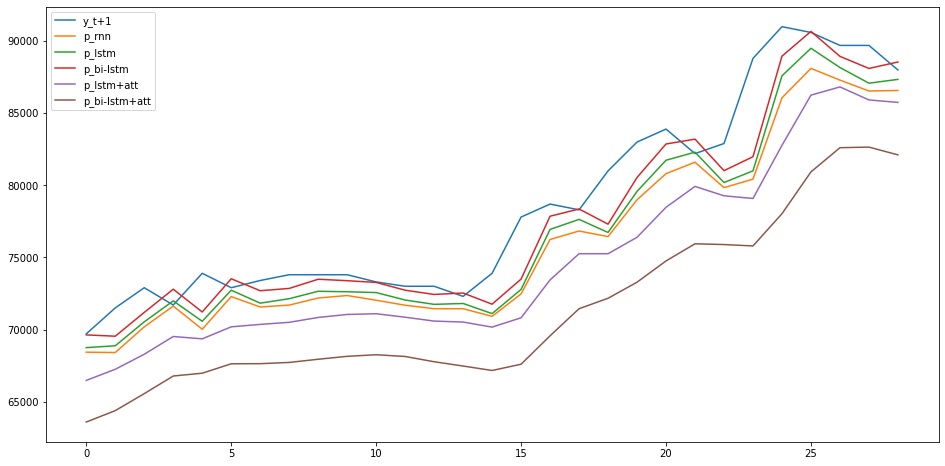

In [83]:
result.plot(figsize=(16,8))